# Temporal and Spatial Distribution and Impact of Influenza

**Group members:**

* Yizhou Zhao, mrzhao@ucdavis.edu, 915991479
* Yibo Yan, ybyan@ucdavis.edu, 916129017
* Yuxin Jiang, yyxjiang@ucdavis.edu, 916117618
* Ziyue Wan, zywan@ucdavis.edu, 915986390

## Introduction

The COVID-19 pandemic has led to a devastating loss of human life worldwide and presents an unprecedented challenge to public health, food systems and the world of work. In the context of global pandemic, analyzing infectious disease characteristics and trends, evaluating its impact have become pressing needs for pandemic recovery and prevention. As a result, we choose to analyze data of Influenza in this project. Our goal is to find the temporal trend, spatial trend, and impact of influenza on people's online behabior. The conclusion of the project would be used to help the prevention and revory from the epidemic.

## Statistical Questions of Interest

In order to reach the conclusion mentioned in the introduction, we separated the research question into three sub-questions. The first question of interest is to analyze the regional and temporal distribution the Influenza case number and illiness rate, and find the possible factor that can make influence on the distribution. In this section, we mainly visualized the data by region using matplotlib to make the guess, and adopt correlation function to jutisfy it. The second question is how average influenza hospitalization rates distribute in different age group. In the analysis of this question, we calculated the hospitality rate of each group, visualized it, and found Influenza is more infections in which age group. The last one is how does Influenza impact people's online activities. In this section, we drawed the plot of the number of illiness case and flu-related website hit number of Google to see their trend and correlation. The detail of the project would be included in the following sections.

## Main Analysis

In [ ]:
import os
import sys

# Import Code modules
module_path = os.path.abspath(os.path.join('../code'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from data_fetcher import DataFetcher
from endpoint_type import EndpointType
from db_connector import DBConnector
from flusurv_params import *
from fluview_params import *
from gft_params import *

db_connector = DBConnector()

In [4]:
import requests
import pandas as pd
import numpy as np
import sqlalchemy as sqla
import requests_cache
import plotnine as p9
import datetime as date
import matplotlib.pyplot as plt
import numpy as np
pd.set_option("display.max_rows", None)
requests_cache.install_cache('covidcast_cache')

### **1 Regional Distribution of Influenza Cases**

**1.1 Regional Distribution**

In [99]:
fluview_param = FluViewParams(
    epiweeks = ["202001-202053"],
    regions = [FluViewRegion.HHS1,FluViewRegion.HHS2,FluViewRegion.HHS3,FluViewRegion.HHS4,FluViewRegion.HHS5,FluViewRegion.HHS6,FluViewRegion.HHS7,FluViewRegion.HHS8,FluViewRegion.HHS9,FluViewRegion.HHS10]
)

region_df = DataFetcher.fetch(
    endpoint = EndpointType.FLUVIEW, 
    param = fluview_param
)


In [154]:
query = f"""
SELECT region, SUM(num_ili) AS num_iliness FROM {DBConnector.resolveTableName(EndpointType.FLUVIEW)} GROUP BY region
"""

hhs_df = db_connector.read(query)
hhs_df = hhs_df.loc[hhs_df['region']!='cen2']
hhs_df['region']=['Boston','Seattle','New York','Philadelphia','Atlanta','Chicago','Dallas',' Kansas City','Denver','San Francisco']


We adopted HHS regions in this analysis where HHS1 includes Connecticut, Maine, Massachusetts, and New Hampshire Rhode Island, Vermont (Boston Region), HHS2 includes New Jersey, New York, Puerto Rico, and U.S. Virgin Islands (New York Region), HHS3 includes Delaware, District of Columbia,Maryland, Pennsylvania, Virginia, West Virginia (Philadelphia Region), HH4 includes Alabama, Florida, Georgia, Kentucky, Mississippi, North Carolina, South Carolina, Tennessee (Atlanta Region), HHS5 includes Illinois, Indiana, Michigan, Minnesota, Ohio, Wisconsin (Chicago Region), HHS6 includes Arkansas, Louisiana, New Mexico, Oklahoma, Texas (Dallas Region), HHS 7 includes Iowa, Kansas, Missouri, Nebraska (Kansas City Region), HHS8 includes Colorado, Montana, North Dakota, South Dakota, Utah, Wyoming (Denver Region), HHS9 includes American Samoa, Arizona, California, Commonwealth of the Northern Mariana Islands, Guam, Hawaii, Nevada, Republic of Palau, Republic of the Marshall Islands (San Francisco Region), HHS10 includes Alaska, Idaho, Oregon, Washington (Seattle Region).


According to the number of Influenza illiness cases regional distribution bar chart in 2020 below, we can conclude that Atlanta region has the largest number of cases, and the number of cases in north east of America is larger than other regions.

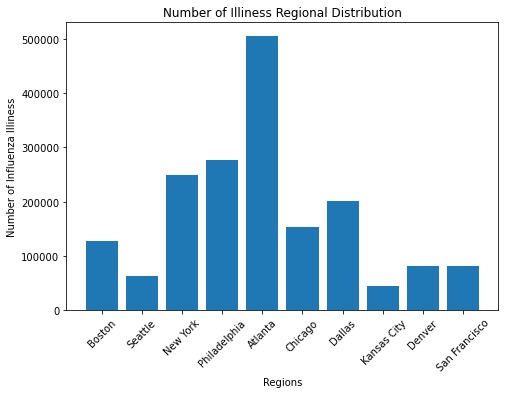

In [102]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(hhs_df["region"].tolist(),hhs_df["num_iliness"].tolist())
plt.xticks(rotation=45)
plt.title("Number of Illiness Regional Distribution")
plt.xlabel("Regions")
plt.ylabel("Number of Influenza Illiness")
plt.show()

Then we are curious about the cause of this regional distribution. Volume of transportation is usually an esential factor that could influence the number of epidemic disease cases, so we choose number of airports in the region as a possible factor.

In [ ]:
region_df['rat_ili']=region_df['num_ili']/region_df['num_patients']
region_rat=region_df.groupby("region")["region","rat_ili"].sum('num_rat').reset_index()
region_rat['rat_ili']=region_rat['rat_ili']/53
region_rat['region']=['Boston','Seattle','New York','Philadelphia','Atlanta','Chicago','Dallas',' Kansas City','Denver','San Francisco']

In [161]:
# Source of airport data: https://www.globalair.com/airport/state.aspx
airport_df_temp ={'region':['Boston','Seattle','New York','Philadelphia','Atlanta','Chicago','Dallas',' Kansas City','Denver','San Francisco'], 'num_airport':[866,2059,939,1610,3272,3434,3577,1459,1535,1386]}
airport_df = pd.DataFrame(data=airport_df_temp)

We draw the barcharts of regional distribution of Influenza Illiness rate and airport number and found that they have the similar trend. As a result, we guess the correlation between number of airports and Influenza Illiness rate is positive.

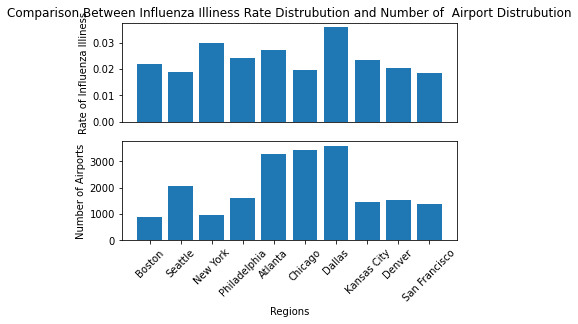

In [163]:
from matplotlib import pyplot as plt
plt.subplot(2, 1, 1) # row 1, col 2 index 1
rate=plt.bar(region_rat["region"].tolist(),region_rat["rat_ili"].tolist())
plt.xticks([],[])
plt.title("Comparison Between Influenza Illiness Rate Distrubution and Number of  Airport Distrubution")
# plt.xlabel("Regions")
plt.ylabel("Rate of Influenza Illiness")

plt.subplot(2, 1, 2) # index 2
airport=plt.bar(airport_df["region"].tolist(),airport_df["num_airport"].tolist())
plt.xticks(rotation=45)
# plt.title("Number of Airports of HHS Regions")
plt.xlabel("Regions")
plt.ylabel("Number of Airports")

plt.show()

The correlation of number of airports and Influenza Illiness rate is 0.35, which indicates that the Influenza Illiness rate tend to be high in regions that have large transportation volume.

In [164]:
region_rat["rat_ili"].corr(airport_df["num_airport"])

0.3510850896815788

**1.2 Regional Distribution In Certain Time Period**

After analyzing the regional effect, we wonder whether Influenza has seasonality. We choose summer (June to August) and winter (November to Febuary) to do the comparison.

According to the camparison of bar charts of the case number distribution in summer and winter below, the number of cases in winter is significantly larger than that in summer. So, Influenza does have seasonality.

<ipython-input-166-0e094d9294d2>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
<ipython-input-166-0e094d9294d2>:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


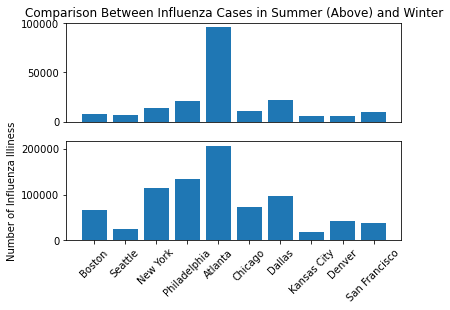

In [166]:
summer_week = [*range(202023,202036)]
region_sm = region_df.loc[region_df['epiweek'].isin(spring_week)]
region_summer = region_sm.groupby("region")["region","num_ili"].sum('num_ili').reset_index()
region_summer['region'] = ['Boston','Seattle','New York','Philadelphia','Atlanta','Chicago','Dallas',' Kansas City','Denver','San Francisco']

winter_week = [*range(202049,202053), *range(202001,202009)]
region_wt = region_df.loc[region_df['epiweek'].isin(winter_week)]
region_winter = region_wt.groupby("region")["region","num_ili"].sum('num_ili').reset_index()
region_winter['region'] = ['Boston','Seattle','New York','Philadelphia','Atlanta','Chicago','Dallas',' Kansas City','Denver','San Francisco']

plt.subplot(2, 1, 1) # row 1, col 2 index 1
summer=plt.bar(region_summer["region"].tolist(),region_summer["num_ili"].tolist())
plt.xticks([],[])
plt.title("Comparison Between Influenza Cases in Summer (Above) and Winter")
# plt.xlabel("Regions")

plt.subplot(2, 1, 2) # index 2
winter=plt.bar(region_winter["region"].tolist(),region_winter["num_ili"].tolist())
plt.xticks(rotation=45)
plt.ylabel("Number of Influenza Illiness")

plt.show()

### 2 Hospitality Rate Analysis

In [38]:
# Check the epiweeks avaliable in the data set
query1 = f"""
SELECT DISTINCT epiweek FROM
{DBConnector.resolveTableName(EndpointType.FLUSURV)} 
"""
epiweek = db_connector.read(query1)
epiweek


,epiweek
0,202003
1,202004
2,202001
3,202002
4,202005
5,202006
6,202007
7,202008
8,202009
9,202010


By selecting location from FLUSURV dataset, we can see that there are three states: Califronia, Colorado, and Oregon. Also, selecting weeks from FLUSURV dataset shows that 2019 year has 30 weeks which from week 1 to week 17 and from week 40 to week 52. However, 2020 year has 17 weeks which from week 1 to week 17. Thus, we will choose Califronia 2020 year data and Colorado 2019 year data to study our problem. 

**2.1**

In this section, we looked at how average influenza hospitalization rates distribute in different age group in California. The data, FluSurv, was used to explore this question. Weekly rates of influenza virus positive specimens correspond to "rate_age_0", "rate_age_1", "rate_age_2", "rate_age_3" and "rate_age_4" by age groups of "0-4 years", "5-24 years", "25-50 years", "51-64 years" and "≥65 years". Since this data contains only 17 weeks, we chose "202001-202017" as the time range and used FluSurvRegion.CA to extract the data for California. Then, we found the average influenza hospitalization rate for different age groups over the 17 weeks by summing the influenza hospitalization rates and dividing by 17. After doing this, we used matplotlib to plot the bar chat. From the following graph, we can see that the highest mean influenza Hospitalization Rate is for people over 65 years old at 8.441176, while the lowest mean influenza hospitalization rate is for people between 5-24 years old at 0.805882, but age group "25-50 years" has a close number 0.958824.

**2020 Data of California**

In [23]:
flusurv_param = FluSurvParams(
    epiweeks = ["202001-202017"], 
    regions = [FluSurvRegion.CA]
)
flusurv=DataFetcher.fetch(EndpointType.FLUSURV,param=flusurv_param)
flusurv

,release_date,location,issue,epiweek,lag,rate_age_0,rate_age_1,rate_age_2,rate_age_3,rate_age_4,rate_overall
0,2020-11-06,CA,202044,202001,43,8.6,0.8,1.5,5.7,15.3,4.7
1,2020-11-06,CA,202044,202002,42,4.0,1.2,1.2,5.2,17.4,4.6
2,2020-11-06,CA,202044,202003,41,3.5,1.5,2.6,5.2,12.0,4.4
3,2020-11-06,CA,202044,202004,40,1.5,2.1,1.7,5.5,17.6,4.9
4,2020-11-06,CA,202044,202005,39,3.5,1.5,1.5,5.9,13.0,4.2
5,2020-11-06,CA,202044,202006,38,4.0,1.7,1.3,5.2,14.4,4.3
6,2020-11-06,CA,202044,202007,37,2.0,1.7,1.4,6.5,12.7,4.2
7,2020-11-06,CA,202044,202008,36,5.5,1.0,1.2,5.7,14.8,4.3
8,2020-11-06,CA,202044,202009,35,1.5,0.6,1.7,4.6,11.3,3.5
9,2020-11-06,CA,202044,202010,34,3.0,0.4,0.6,3.2,8.4,2.4


In [24]:
flusuraverage=flusurv.sum()[['rate_age_0','rate_age_1','rate_age_2','rate_age_3','rate_age_4']]/17
flusuraverage

rate_age_0    2.329412
rate_age_1    0.805882
rate_age_2    0.958824
rate_age_3    3.276471
rate_age_4    8.441176
dtype: object

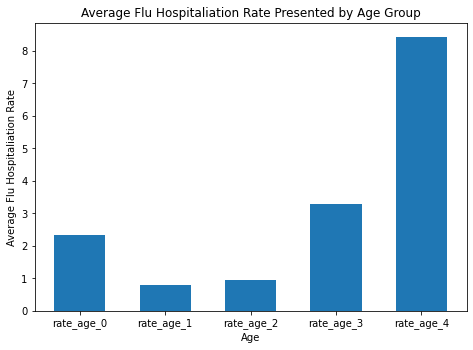

In [25]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
age = ['rate_age_0','rate_age_1','rate_age_2','rate_age_3','rate_age_4']
average_rate  = [2.329412,0.805882,0.958824,3.276471,8.441176]
plt.bar(age, average_rate,
        width = 0.6)
plt.xlabel("Age")
plt.ylabel("Average Flu Hospitaliation Rate")
plt.title("Average Flu Hospitaliation Rate Presented by Age Group")
plt.show()

In [26]:
flusurvCA=flusurv.drop(['release_date','location','issue','lag','epiweek'], axis = 1)
flusurvCA

,rate_age_0,rate_age_1,rate_age_2,rate_age_3,rate_age_4,rate_overall
0,8.6,0.8,1.5,5.7,15.3,4.7
1,4.0,1.2,1.2,5.2,17.4,4.6
2,3.5,1.5,2.6,5.2,12.0,4.4
3,1.5,2.1,1.7,5.5,17.6,4.9
4,3.5,1.5,1.5,5.9,13.0,4.2
5,4.0,1.7,1.3,5.2,14.4,4.3
6,2.0,1.7,1.4,6.5,12.7,4.2
7,5.5,1.0,1.2,5.7,14.8,4.3
8,1.5,0.6,1.7,4.6,11.3,3.5
9,3.0,0.4,0.6,3.2,8.4,2.4


Then, we want to study time trend of influenza hospitalization rates for different age group in California over 2020 year. We drop the columns of 'release_date', 'location', 'issue', 'lag', 'epiweek' to create a new datafram named flusurvCA. Using code "plot" to visulize the time trend. From the following graphs, we can see that they almost all have the decreasing trend. There is a small difference in age groups between "5-24 years” and "25-50 years",they have increasing trend from week 1 to week 2. Overall, after week 4, the influenza hospitalization rates reduce quickly for every age group.

array([<AxesSubplot:xlabel='epiweeks', ylabel='average rates'>,
       <AxesSubplot:xlabel='epiweeks', ylabel='average rates'>,
       <AxesSubplot:xlabel='epiweeks', ylabel='average rates'>,
       <AxesSubplot:xlabel='epiweeks', ylabel='average rates'>,
       <AxesSubplot:xlabel='epiweeks', ylabel='average rates'>,
       <AxesSubplot:xlabel='epiweeks', ylabel='average rates'>],
      dtype=object)

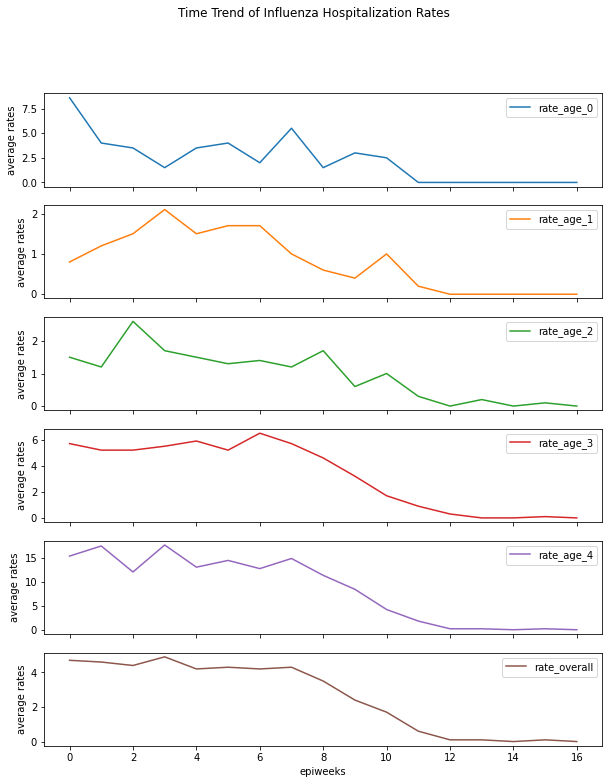

In [27]:
flusurvCA.plot(subplots=True, figsize=(10,12),
               xlabel="epiweeks",ylabel="average rates",
              title="Time Trend of Influenza Hospitalization Rates")

**2.2**

Then, we want to study the same question for Colorado. Since FLuSurve does not contain 2021 year data for Colorado, so we study average influenza hospitalization rates in 2019 year, and 2019 data has 30 weeks with missing value between 17 and 40 weeks. Thus, we choose "201901-201917" and "201940-201952" as the time range and used FluSurvRegion.CO to extract the data for Colorado. Then, we found the average influenza hospitalization rate for different age groups over the 30 weeks by summing the influenza hospitalization rates and dividing by 30. After doing this, we used matplotlib to plot the bar chat. Similarly, from the above graph, we can see that the highest mean influenza hospitalization rate is for people over 65 years old at 6.63, while the lowest mean influenza hospitalization rate is for people between "25-50 years" at 0.9, and average rate for people who are between "5-24 years" old close to people between 25-64 years old, which is 0.913333.

2021 Data of Colorado

In [28]:
flusurv_param1 = FluSurvParams(
    epiweeks = ["201901-201917","201940-201952"], 
    regions = [FluSurvRegion.CO]
)
flusurv1=DataFetcher.fetch(EndpointType.FLUSURV,param=flusurv_param1)
flusurv1

,release_date,location,issue,epiweek,lag,rate_age_0,rate_age_1,rate_age_2,rate_age_3,rate_age_4,rate_overall
0,2020-01-10,CO,202001,201901,52,8.2,0.6,3.3,11.5,13.1,5.9
1,2020-01-17,CO,202002,201902,52,4.1,1.9,2.8,6.6,10.6,4.4
2,2020-01-24,CO,202003,201903,52,4.1,0.4,1.5,4.0,6.7,2.6
3,2020-01-31,CO,202004,201904,52,5.3,1.1,0.8,3.8,5.8,2.3
4,2020-02-07,CO,202005,201905,52,6.5,0.6,0.8,3.0,4.2,1.9
5,2020-02-14,CO,202006,201906,52,5.9,1.3,0.5,3.2,8.6,2.5
6,2020-02-21,CO,202007,201907,52,7.1,0.9,0.6,4.0,8.9,2.7
7,2020-02-28,CO,202008,201908,52,3.5,2.4,1.3,3.2,15.9,3.8
8,2020-03-06,CO,202009,201909,52,5.9,2.8,1.8,4.4,15.0,4.4
9,2020-03-13,CO,202010,201910,52,12.4,2.4,1.7,5.0,20.6,5.5


In [29]:
flusuraverage1=flusurv1.sum()[['rate_age_0','rate_age_1','rate_age_2','rate_age_3','rate_age_4']]/30
flusuraverage1

rate_age_0    3.386667
rate_age_1    0.913333
rate_age_2         0.9
rate_age_3    2.636667
rate_age_4        6.63
dtype: object

<ipython-input-30-719ca84fbceb>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


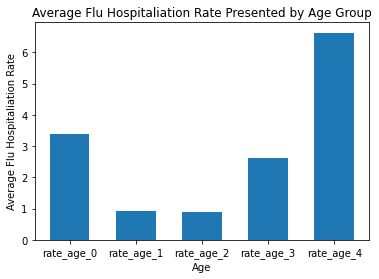

In [30]:
import matplotlib.pyplot as plt
fig1 = plt.figure()
ax1 = fig.add_axes([0,0,1,1])
age1 = ['rate_age_0','rate_age_1','rate_age_2','rate_age_3','rate_age_4']
average_rate1  = [ 3.386667,0.913333,0.9,2.636667,6.63]
plt.bar(age1, average_rate1,
        width = 0.6)
plt.xlabel("Age")
plt.ylabel("Average Flu Hospitaliation Rate")
plt.title("Average Flu Hospitaliation Rate Presented by Age Group")
plt.show()

### 3 Impact on People's Online Activity

In the this sections, we want to solve the research question that how influenza illness case number impacts the flu-related website hit number of Google. Therefore, the API data endpoints we use in this section are 'FlueView' and 'Google Flu Trend'. Variables "num_ili" (the influenza illness case number) and "num" (the flu-related website hit number of Google) are included in this section.

Before analyzing, we first request the API with the parameters we want. we request the data with epiweek from 2013 to 2015, which means that it will show weekly data from 2013 to 2015. The region we request from this data is 'national', which is the national data in the US.

In [20]:
# Check the regions we can use
query = f"""
SELECT region FROM {DBConnector.resolveTableName(EndpointType.FLUVIEW)} GROUP BY region
"""

region = db_connector.read(query)
region

,region
0,cen2
1,hhs1
2,hhs10
3,hhs2
4,hhs3
5,hhs4
6,hhs5
7,hhs6
8,hhs7
9,hhs8


**3.1**

In [5]:
fluview_param = FluViewParams(
    epiweeks = "201300-201547",
    regions = [FluViewRegion.NAT]
)

flueview_data = DataFetcher.fetch(
    endpoint = EndpointType.FLUVIEW, 
    param = fluview_param
)

In [6]:
gft_param = GTFParams(
    epiweeks = "201300-201547",
    regions = [GFTRegion.NAT]
)

gft_data = DataFetcher.fetch(
    endpoint = EndpointType.GFT, 
    param = gft_param
)

In [8]:
data_merge = flueview_data.merge(gft_data, how='inner', on='epiweek')

We firstly draw a scatter plot, in which x-axis is 'num_ili' and y-axis is 'num'. From this plot we can see a positive relationship between thhese two variables

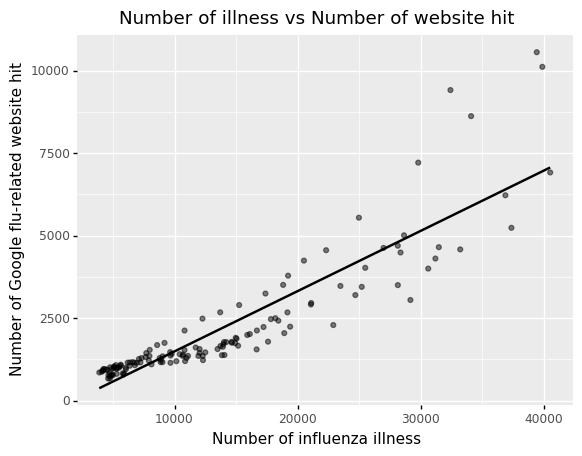

<ggplot: (120628223272)>

In [9]:
(p9.ggplot(data=data_merge,
           mapping=p9.aes(x='num_ili',
                          y='num'))
   + p9.geom_point(alpha=0.5)
   + p9.xlab("Number of influenza illness")
   + p9.ylab("Number of Google flu-related website hit")
   + p9.labs(title='Number of illness vs Number of website hit')
   + p9.geom_smooth(method='lm',se=False))

In [10]:
data_merge['epiweek'] = data_merge['epiweek'].astype(int)-1
data_merge['epiweek'] = data_merge['epiweek'].astype(str)

In [11]:
data_merge['epiweek'] = pd.to_datetime(data_merge['epiweek'] + "0", format="%Y%W%w")

Then we draw a time trend plot of the the number of Influenza cases and the flu-related website hit number of Google in one graph. From the plot following, we can see two lines. The red line is the time trend of 'num', and the green line is the trend of 'num_ili'. These two lines show exactly similar trend from 2013 to 2015. From the similar trend, we can make a conclusion that when the influenza illness case number is large, the flu-related website hit number of Google will also be large. We can say that people will search influenza related website in Google more frequently when flu is prevailing.

Text(0, 0.5, 'Number of influenza illness')

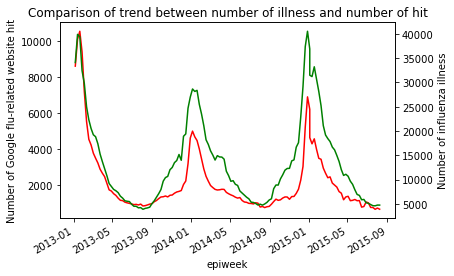

In [12]:
data_merge = data_merge.set_index('epiweek')
df = pd.Series(data = data_merge['num'], index = data_merge.index)
df2 = pd.Series(data = data_merge['num_ili'], index = data_merge.index)
df.plot(color='red', title = 'Comparison of trend between number of illness and number of hit').set_ylabel('Number of Google flu-related website hit')
df2.plot(color='green', secondary_y=True).set_ylabel('Number of influenza illness')

**3.2** To check the accuracy of the conclusion we made, we did the same analysis on data requested from region 'hhs1' to 'hhs10'. I summed the data of all the regions on each epiweek to obtain the data for theh whole country.The plots following show the same result with our previous analysis.

In [13]:
fluview_param2 = FluViewParams(
    epiweeks = "201300-201547",
    regions = [GFTRegion.HHS1,GFTRegion.HHS2,GFTRegion.HHS3,GFTRegion.HHS4,GFTRegion.HHS5,GFTRegion.HHS6,
              GFTRegion.HHS7,GFTRegion.HHS8,GFTRegion.HHS9,GFTRegion.HHS10]
)

flueview_data2 = DataFetcher.fetch(
    endpoint = EndpointType.FLUVIEW, 
    param = fluview_param2
)

In [14]:
flueview_data2 = flueview_data2.groupby('epiweek')['num_patients', 'num_ili'].sum()

<ipython-input-14-6bb6ccf8c427>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [15]:
gft_param2 = GTFParams(
    epiweeks = "201300-201547",
    regions = [GFTRegion.HHS1,GFTRegion.HHS2,GFTRegion.HHS3,GFTRegion.HHS4,GFTRegion.HHS5,GFTRegion.HHS6,
              GFTRegion.HHS7,GFTRegion.HHS8,GFTRegion.HHS9,GFTRegion.HHS10]
)

gft_data2 = DataFetcher.fetch(
    endpoint = EndpointType.GFT, 
    param = gft_param2
)

In [16]:
gft_data2 = gft_data2.groupby('epiweek').sum()

In [17]:
data_merge2 = flueview_data2.merge(gft_data2, how='inner', on='epiweek')
data_merge2 = data_merge2.reset_index()
data_merge2['epiweek'] = data_merge2['epiweek'].astype(int)-1
data_merge2['epiweek'] = data_merge2['epiweek'].astype(str)
data_merge2['epiweek'] = pd.to_datetime(data_merge2['epiweek'] + "0", format="%Y%W%w")

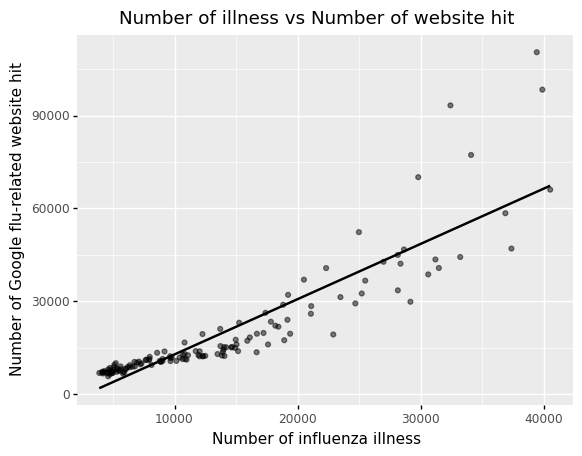

<ggplot: (120627144647)>

In [18]:
(p9.ggplot(data=data_merge2,
           mapping=p9.aes(x='num_ili',
                          y='num'))
   + p9.geom_point(alpha=0.5)
   + p9.xlab("Number of influenza illness")
   + p9.ylab("Number of Google flu-related website hit")
   + p9.labs(title='Number of illness vs Number of website hit')
   + p9.geom_smooth(method='lm',se=False))

Text(0, 0.5, 'Number of influenza illness')

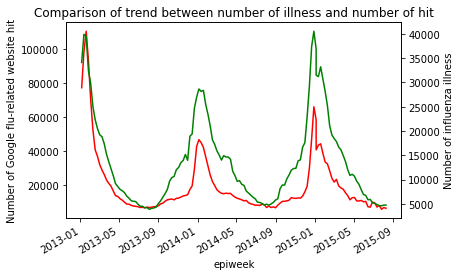

In [19]:
data_merge2 = data_merge2.set_index('epiweek')
data = pd.Series(data = data_merge2['num'], index = data_merge2.index)
data2 = pd.Series(data = data_merge2['num_ili'], index = data_merge2.index)
data.plot(color='red', title = 'Comparison of trend between number of illness and number of hit').set_ylabel('Number of Google flu-related website hit')
data2.plot(color='green', secondary_y=True).set_ylabel('Number of influenza illness')

In this section, it is fortunate that the data I request to use is going well when analyzing. However, there are still some limitation on this data to analyze. For example, normally, the data for 'national' and for the sum of all 'hhs' should be almost the same, because the they all stand for the data in the whole USA, while in this API they are totally different.

## Conclusion

In conclusion, for the temporal and spacial trend, Atlanta region and north east of America have largest number of Influenza illiness cases, illiness rate is potively related to the volume of transportations in regions, and Influenza epidemic is more serious in winter than summer. 

For the hospitality rate analysis, we reached the conclusion that people who are over 65 years old have the largest hospitalization rate while people between 5-24 years old have the lowest. We can also conclude that hospitalizaion rate for age groups almost all have the decreasing trend. There is a small difference in age groups between "5-24 years” and "25-50 years",they have increasing trend from week 1 to week 2. Overall, after week 4, the influenza hospitalization rates reduce quickly for every age group.

For the analysis of Influenza's impact on people's online activity, out conclusion is that people will search influenza related website in Google more frequently when flu is prevailing.